# ⛵ 캐글 산탄데르 고객 만족 예측

캐글의 산탄데르 고객 만족 데이터 세트에 대해서 고객 만족 여부를 XGBoost와 LightGBM을 통해 예측해봅시닷!

분석의 목적!
370개의 feature로 주어진 데이터 세트 기반에서 고객 만족 여부를 예측하는 것!

클래스 레이블 이름 : TARGET
##### 1이면 불만을 가진 고객, 0이면 만족한 고객

In [ ]:
# 필요한 라이브러리

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import time

# sklearn 관련
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV

# xgboost 관련
from xgboost import XGBClassifier
from xgboost import plot_importance

# lightgbm 관련
from lightgbm import LGBMClassifier
from lightgbm import plot_importance

https://www.kaggle.com/competitions/santander-customer-satisfaction/code
##### 캐글 홈페이지에서 자료를 다운받은 뒤,
- Colab 사용 시 : 화면 왼쪽에 있는 폴더 아이콘을 클릭! train, test 파일을 옮겨놓으면 끝!
- Jupyter Notebook 사용 시 : 작업 중인 폴더 내에 train, test 파일을 업로드 해놓으면 끝!

In [ ]:
# 데이터 살펴보기

cust_df = pd.read_csv('./train.csv', encoding = 'latin-1')
print(cust_df.shape)
cust_df.head(3)

(76020, 371)


,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.17,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.03,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.77,0


다음과 같이 14,776개의 행과 371개의 열을 가진 데이터로, 우리가 예측할 변수는 'TARGET'에 저장되어 있습니다!

In [ ]:
cust_df['TARGET'].value_counts() # 0 : 만족, 1 : 불만족

0    73012
1     3008
Name: TARGET, dtype: int64

이 TARGET 변수는 이항형(binary)이고, 만족하는 고객은 14,178명, 만족하지 않는 고객은 597명으로 불만족인 고객은 4% 정도에 불과합니다!

In [ ]:
# 데이터 전처리하기

cust_df.describe()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,...,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,...,455.887218,113.959637,783.207399,538.439211,2013.125393,147.786584,4040.337842,2852.579397,1.826646e+05,0.194945
min,1.000000,-999999.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.163750e+03,0.000000
25%,38104.750000,2.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.787061e+04,0.000000
50%,76043.000000,2.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.064092e+05,0.000000
75%,113748.750000,2.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.187563e+05,0.000000
max,151838.000000,238.000000,105.000000,210000.000000,12888.030000,21024.810000,8237.820000,11073.570000,6600.000000,6600.000000,...,50003.880000,20385.720000,138831.630000,91778.730000,438329.220000,24650.010000,681462.900000,397884.300000,2.203474e+07,1.000000


전처리할 변수는 2가지 입니다!
- var3의 최소값이 -999999로 되어 있는데, 이를 가장 값이 많은 2로 변환하고자 합니다!
##### 아마도 특정 예외값 혹은 null값을 -999999로 변환했기 때문!
- ID feature는 단순 식별자이기 때문에 feature를 드롭!

In [ ]:
cust_df['var3'].replace(-999999, 2, inplace = True)
cust_df.drop('ID', axis = 1, inplace = True)

이제 XGBoost와 LightGBM 모형 훈련을 위해 훈련 데이터와 테스트 데이터를 나누는 작업을 해야 합니다! 이를 위해 sklearn의 train_test_split 메서드를 이용했고, 테스트 데이터의 크기와 훈련 데이터의 비율은 2:8로 했습니다!

In [ ]:
# X랑 y 나누기

X = cust_df.iloc[:, :-1]
y = cust_df.iloc[:, -1]

X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size = 0.2, random_state = 0)

print(y_train.value_counts() / y_train.count())
print(y_eval.value_counts() / y_eval.count())

0    0.960964
1    0.039036
Name: TARGET, dtype: float64
0    0.9583
1    0.0417
Name: TARGET, dtype: float64


훈련 데이터와 테스트 데이터 모두 TARGET의 값의 분포가 원본 데이터와 유사하게 전체 데이터의 4% 정도로 불만족 값이 나오도록 만들어진 것을 확인할 수 있습니다!

## XGBoost 모델 학습 & 하이퍼 파라미터 튜닝

이제 XGBoost의 학습 모델을 생성하고 예측 결과를 ROC AUC로 평가해봅시다! 그리고 시작과 끝 시간을 재어서 XGBoost와 LightGBM의 수행 속도를 비교해봅시다!

In [ ]:
tic = time.time() # 시작 시간

# 학습
xgb = XGBClassifier(n_estimators = 500, random_state = 156)
xgb.fit(X_train, y_train, early_stopping_rounds = 100,
       eval_metric = "auc", eval_set = [(X_train, y_train), (X_eval, y_eval)])
xgb_roc_score = roc_auc_score(y_eval, xgb.predict_proba(X_eval)[:, 1], average = 'macro')

toc = time.time() # 끝 시간

print('ROC AUC: {0:.4f}'.format(xgb_roc_score))
print('time elapsed:', toc - tic)

[0]	validation_0-auc:0.799928	validation_1-auc:0.803548
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[1]	validation_0-auc:0.802222	validation_1-auc:0.805222
[2]	validation_0-auc:0.80819	validation_1-auc:0.813162
[3]	validation_0-auc:0.8127	validation_1-auc:0.813243
[4]	validation_0-auc:0.81648	validation_1-auc:0.816979
[5]	validation_0-auc:0.816018	validation_1-auc:0.816629
[6]	validation_0-auc:0.816474	validation_1-auc:0.817776
[7]	validation_0-auc:0.818148	validation_1-auc:0.818464
[8]	validation_0-auc:0.81806	validation_1-auc:0.818295
[9]	validation_0-auc:0.817039	validation_1-auc:0.818087
[10]	validation_0-auc:0.818318	validation_1-auc:0.818749
[11]	validation_0-auc:0.818711	validation_1-auc:0.818521
[12]	validation_0-auc:0.818673	validation_1-auc:0.818516
[13]	validation_0-auc:0.819156	validation_1-auc:0.818998
[14]	validation_0-auc:0.819847	validation_1-auc:0.81999
[15

Grid Search 없이 weak learner 개수(n_estimators)를 500, EarlyStopping 반복 횟수 (early_stopping_rounds)를 100으로 했을 때 걸린 시간은 177초, ROC AUC는 0.8419

이제 성능을 높이기 위한 하이퍼 파라미터 튜닝을 시도해봅시다! Column 개수가 371개로 많은 편이기 때문에 overfitting 방지를 위해 max_depth, min_child_weight, colsample_bytree 하이퍼 파라미터만 일차적으로 튜닝 대상을 삼습니다!

다음은 8개의 하이퍼 파라미터의 경우의 수를 가집니다! 수행 시간이 꽤 오래 걸리므로 weak learner의 개수를 100개, fold의 개수를 3개로, early_stopping_rounds를 30으로 줄여서 테스트한 뒤 나중에 하이퍼 파라미터 튜닝이 완료되면 다시 바꾸도록 합시다!

In [ ]:
tic = time.time()

# Grid Search
xgb = XGBClassifier(n_estimators = 100, random_state = 156)

# Hyperparameter 후보
params = {'max_depth':[5, 7], 'min_child_weight':[1, 3], 'colsample_bytree': [0.5, 0.75]}

# folds = 3
gridcv = GridSearchCV(xgb, param_grid = params, cv = 3)
gridcv.fit(X_train, y_train, early_stopping_rounds = 30, eval_metric = "auc",
           eval_set = [(X_train, y_train), (X_eval, y_eval)])
xgb_roc_score = roc_auc_score(y_eval, gridcv.predict_proba(X_eval)[:, 1], average = 'macro')

toc = time.time()

print('Optimized hyperparameters', gridcv.best_params_)
# {'colsample_bytree': 0.75, 'max_depth': 5, 'min_child_weight': 3}
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))
print('time elapsed:', toc - tic)

[0]	validation_0-auc:0.808554	validation_1-auc:0.808312
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.813657	validation_1-auc:0.813928
[2]	validation_0-auc:0.803792	validation_1-auc:0.811241
[3]	validation_0-auc:0.818094	validation_1-auc:0.819595
[4]	validation_0-auc:0.822706	validation_1-auc:0.824675
[5]	validation_0-auc:0.811541	validation_1-auc:0.815635
[6]	validation_0-auc:0.824344	validation_1-auc:0.823535
[7]	validation_0-auc:0.829825	validation_1-auc:0.827602
[8]	validation_0-auc:0.834345	validation_1-auc:0.831343
[9]	validation_0-auc:0.835108	validation_1-auc:0.831486
[10]	validation_0-auc:0.833181	validation_1-auc:0.830521
[11]	validation_0-auc:0.831342	validation_1-auc:0.829627
[12]	validation_0-auc:0.826319	validation_1-auc:0.825715
[13]	validation_0-auc:0.8319	validation_1-auc:0.829615
[14]	validation_0-auc:0.834867	validation_1-auc:0.831223


이전에 하이퍼 파라미터 튜닝 없이 얻은 ROC AUC 0.8419에 비해, 최적의 파라미터 {'colsample_bytree':0.75, 'max_depth':5, 'min_child_weight':1}로 했을 때 0.003 정도 ROC AUC가 높아졌음을 확인할 수 있습니다!

이제 앞에서 구한 최적의 파라미터를 기반으로 다른 하이버 파라미터를 변경 또는 추가해 다시 최적화를 진행해봅시다!

위에서 구한 최적의 하이퍼 파라미터를 {‘colsample_bytree’: 0.75, ‘max_depth’: 5, ‘min_child_weight’: 1}로 설정한 뒤, n_estimators = 1000으로 증가시키고, learning_rate = 0.02로 감소시킵니다! 그리고 reg_alpha = 0.03을 추가합니다!

In [ ]:
tic = time.time()

xgb = XGBClassifier(
    colsample_bytree = 0.75, max_depth = 5, min_child_weight = 1,
    n_estimators = 1000,random_state = 156,
    learning_rate = 0.02, reg_alpha = 0.03
) # 위의 최적 파라미터 결과

xgb.fit(X_train, y_train, early_stopping_rounds = 200, eval_metric = "auc",
       eval_set = [(X_train, y_train), (X_eval, y_eval)])

xgb_roc_score = roc_auc_score(y_eval, xgb.predict_proba(X_eval)[:,1] ,average='macro')

toc = time.time()

print('ROC AUC: {0:.4f}'.format(xgb_roc_score))
print('time elapsed:', toc - tic)

[0]	validation_0-auc:0.817284	validation_1-auc:0.811534
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 200 rounds.
[1]	validation_0-auc:0.820302	validation_1-auc:0.812178
[2]	validation_0-auc:0.823363	validation_1-auc:0.816027
[3]	validation_0-auc:0.825007	validation_1-auc:0.81705
[4]	validation_0-auc:0.825243	validation_1-auc:0.817264
[5]	validation_0-auc:0.827563	validation_1-auc:0.819988
[6]	validation_0-auc:0.827812	validation_1-auc:0.819542
[7]	validation_0-auc:0.827855	validation_1-auc:0.819216
[8]	validation_0-auc:0.829221	validation_1-auc:0.819799
[9]	validation_0-auc:0.829078	validation_1-auc:0.818898
[10]	validation_0-auc:0.830731	validation_1-auc:0.820967
[11]	validation_0-auc:0.828293	validation_1-auc:0.819437
[12]	validation_0-auc:0.829608	validation_1-auc:0.821204
[13]	validation_0-auc:0.830487	validation_1-auc:0.821121
[14]	validation_0-auc:0.834894	validation_1-auc:0.82706

결과적으로 ROC AUC가 0.8442로 이전 테스트보다 약간 향상된 결과를 나타내고 있네요!

하지만, 앙상블 계열 알고리즘은 기본적으로 overfitting이나 noise에 뛰어난 알고리즘이기 때문에, 하이퍼 파라미터 튜닝으로 성능 수치 개선이 급격이 이뤄지는 경우는 많지 않다고 합니다! 결과적으로 하이퍼 파라미터 튜닝에 그렇게 의존할 필요는 없어 보입니다!

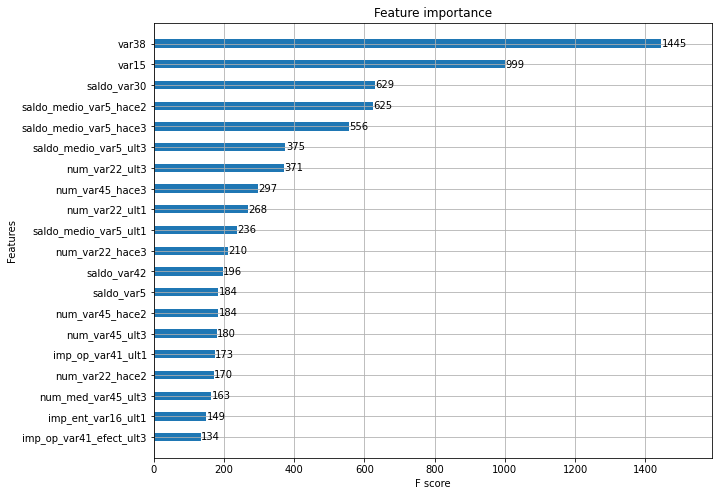

In [ ]:
# 피처 중요도

from xgboost import plot_importance

fig, ax = plt.subplots(figsize = (10, 8))
plot_importance(xgb, ax = ax, max_num_features = 20, height = .4)

## LightGBM 모델 학습 & 하이퍼 파라미터 튜닝

마찬가지로 XGBoost에서 만들어진 데이터 세트를 기반으로 LightGBM 학습을 수행하고 ROC AUC를 측정해봅시다!

In [ ]:
tic = time.time()
lgbm = LGBMClassifier (n_estimators = 500, random_state = 156)

lgbm.fit(X_train, y_train, early_stopping_rounds = 100, eval_metric = "auc", 
         eval_set = [(X_train, y_train), (X_eval, y_eval)])

lgbm_roc_score = roc_auc_score (y_eval, lgbm.predict_proba(X_eval)[:, 1], average = "macro")
toc = time.time()

print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))
print('time elapsed:', toc - tic)

[1]	training's binary_logloss: 0.156016	training's auc: 0.823612	valid_1's binary_logloss: 0.165046	valid_1's auc: 0.817384
Training until validation scores don't improve for 100 rounds.
[2]	training's binary_logloss: 0.150537	training's auc: 0.827721	valid_1's binary_logloss: 0.16	valid_1's auc: 0.81863
[3]	training's binary_logloss: 0.146582	training's auc: 0.838174	valid_1's binary_logloss: 0.156287	valid_1's auc: 0.827411
[4]	training's binary_logloss: 0.143436	training's auc: 0.843175	valid_1's binary_logloss: 0.153416	valid_1's auc: 0.832175
[5]	training's binary_logloss: 0.14091	training's auc: 0.845936	valid_1's binary_logloss: 0.151206	valid_1's auc: 0.83481
[6]	training's binary_logloss: 0.138833	training's auc: 0.847111	valid_1's binary_logloss: 0.149303	valid_1's auc: 0.834721
[7]	training's binary_logloss: 0.137055	training's auc: 0.850065	valid_1's binary_logloss: 0.147804	valid_1's auc: 0.83659
[8]	training's binary_logloss: 0.135438	training's auc: 0.852458	valid_1's bi

결과는 ROC AUC는 0.8396, 걸린 시간은 12초네요!

튜닝을 하지 않은 XGBoost의 결과와 비교했을 때, ROC AUC는 0.0023 더 낮고, 시간은 약 165초 더 빠르게 나왔네요!

마찬가지로 GridSearchCV로 하이퍼 파라미터 튜닝을 수행해봅시다!

In [ ]:
tic = time.time()

params = {
    'max_depth':[128, 160],
    'min_child_samples':[60, 100],
    'subsample':[0.8, 1]
}
lgbm = LGBMClassifier(n_estimator = 100)

gridcv = GridSearchCV(lgbm, param_grid = params, cv = 3)
gridcv.fit(X_train, y_train, early_stopping_rounds = 30, eval_metric = 'auc',
          eval_set = [(X_train, y_train), (X_eval, y_eval)])

lgbm_roc_score = roc_auc_score(y_eval, gridcv.predict_proba(X_eval)[:,1], average = 'macro')

toc = time.time()

print('Optimized hyperparameters', gridcv.best_params_)
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))
print('time elapsed:', toc - tic)

[1]	valid_0's binary_logloss: 0.156116	valid_0's auc: 0.820107	valid_1's binary_logloss: 0.165023	valid_1's auc: 0.815632
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's binary_logloss: 0.151001	valid_0's auc: 0.825543	valid_1's binary_logloss: 0.159945	valid_1's auc: 0.821373
[3]	valid_0's binary_logloss: 0.147225	valid_0's auc: 0.832031	valid_1's binary_logloss: 0.156449	valid_1's auc: 0.827139
[4]	valid_0's binary_logloss: 0.144199	valid_0's auc: 0.83757	valid_1's binary_logloss: 0.153342	valid_1's auc: 0.83326
[5]	valid_0's binary_logloss: 0.14177	valid_0's auc: 0.840565	valid_1's binary_logloss: 0.151004	valid_1's auc: 0.835976
[6]	valid_0's binary_logloss: 0.139764	valid_0's auc: 0.843203	valid_1's binary_logloss: 0.149049	valid_1's auc: 0.837154
[7]	valid_0's binary_logloss: 0.138127	valid_0's auc: 0.844851	valid_1's binary_logloss: 0.147468	valid_1's auc: 0.837653
[8]	valid_0's binary_logloss: 0.136741	valid_0's auc: 0.847018	valid_1's binary_logloss

기존에 약 20분이 걸렸던 XGBoost의 GridSearchCV에 비해 LightGBM의 GridSearchCV는 2분이면 완성이네요!

ROC AUC는 0.8416, 최적의 하이퍼 파라미터는 {‘max_depth’: 128, ‘min_child_samples’: 60, ‘subsample’: 0.8}입니다!

마지막으로 해당 하이퍼 파라미터를 LightGBM에 적용해 다시 학습한 결과입니다!

In [ ]:
tic = time.time()

lgbm = LGBMClassifier(n_estimators = 1000, max_depth = 128,
                      min_child_samples = 60, subsample = 0.8,
                      random_state = 156)
lgbm.fit(X_train, y_train, early_stopping_rounds = 100, eval_metric = "auc",
         eval_set = [(X_train, y_train), (X_eval, y_eval)])
lgbm_roc_score = roc_auc_score(y_eval, lgbm.predict_proba(X_eval)[:,1], average = 'macro')

toc = time.time()

print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))
print('time elapsed:', toc - tic)

[1]	training's binary_logloss: 0.156167	training's auc: 0.823544	valid_1's binary_logloss: 0.165164	valid_1's auc: 0.81662
Training until validation scores don't improve for 100 rounds.
[2]	training's binary_logloss: 0.150935	training's auc: 0.827956	valid_1's binary_logloss: 0.160021	valid_1's auc: 0.819528
[3]	training's binary_logloss: 0.147083	training's auc: 0.837524	valid_1's binary_logloss: 0.156461	valid_1's auc: 0.827239
[4]	training's binary_logloss: 0.144061	training's auc: 0.843209	valid_1's binary_logloss: 0.153544	valid_1's auc: 0.833228
[5]	training's binary_logloss: 0.141642	training's auc: 0.845338	valid_1's binary_logloss: 0.151228	valid_1's auc: 0.835456
[6]	training's binary_logloss: 0.139662	training's auc: 0.847829	valid_1's binary_logloss: 0.149337	valid_1's auc: 0.837447
[7]	training's binary_logloss: 0.137933	training's auc: 0.850996	valid_1's binary_logloss: 0.147795	valid_1's auc: 0.838477
[8]	training's binary_logloss: 0.136423	training's auc: 0.852586	valid

똑같이 ROC AUC는 0.8416이 나왔고, 소요 시간은 9초입니다!

결과적으로, 소수점 둘째 자리까지 ROC AUC 값이 같을 정도로 XGBoost만큼 LightGBM도 우수한 성능을 낸다는 점, 시간이 훨씬 절약된다는 점을 고려했을 때, LightGBM의 승리라고 생각됩니다! 하지만 데이터에 따라 결과는 언제든 달라질 수 있으니 꼭 둘 다 확인해봅시다!